In [7]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')
from IPython.display import display, HTML

import psycopg2
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt

from config.load import load_conf
from db.utils import get_uri_db
#from strategy.examples.ema200_multitimeframes import Ema200MultiTimeframes
#from strategy.examples.ema5_ema12_rsi21 import Ema5Ema12Rsi21
from strategy.examples.triangular_rsi import TriRSI
from strategy.examples.hull_rsi import HullRSI
from strategy.examples.ma500_rsi import MA500Rsi
from strategy.examples.rsi_stochastic import RSIStochastic
from strategy.examples.double_differencing import DoubleDifferencing
#from strategy.examples.outstreched import OutstrechedStrategy
from strategy.examples.equilibrium import Equilibrium
from strategy.examples.hull_rsi_ma500_rsi import HullRSIMA500RSI
from strategy.examples.macd_flip_strategy import MACDFlipStrategy
from strategy.examples.macd_crossover_strategy import MACDCrossOverStrategy
from strategy.examples.fisher_rsi import FisherRSI
from strategy.examples.e_super_trend import ESuperTrend
from strategy.examples.flashing_indicator import FlashingIndicator

from strategy.stop_loss import StopLossATR, StopLossFix, StopLossWithConstraint
from utils.utils import AnnualGranularity, get_candles

In [8]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [9]:
start_date = '2018-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

spreads = {
    'AUD/USD': 1.8e-4,
    'EUR/GBP': 2.3e-4,
    'EUR/USD': 1.3e-4,
    'GBP/USD': 1.8e-4,
    'USD/CAD': 2.2e-4,
    'USD/CHF': 1.7e-4,
    'USD/HKD': 1.4e-4 
}


In [10]:
candles.head()

,table,date,symbol,open,close,low,high,tickqty
0,candle,2018-01-01 20:00:00,AUD/USD,0.78099,0.78044,0.78044,0.78099,2
1,candle,2018-01-01 20:05:00,AUD/USD,0.78044,0.78044,0.78044,0.78044,2
2,candle,2018-01-01 21:20:00,AUD/USD,0.78044,0.78092,0.78044,0.78092,6
3,candle,2018-01-01 21:25:00,AUD/USD,0.78092,0.78130,0.78086,0.78130,12
4,candle,2018-01-01 21:30:00,AUD/USD,0.78130,0.78083,0.78064,0.78130,35


In [1]:
import yfinance as yf

In [34]:
loreal = yf.Ticker("OR.PA")
loreal_hist = loreal.history(period="max", auto_adjust=True)

In [35]:
loreal_hist.reset_index(inplace=True)

In [36]:
loreal_hist.columns = [x.lower() for x in loreal_hist.columns]

In [37]:
loreal_hist.loc[120:125]

,date,open,high,low,close,volume,dividends,stock splits
120,2000-06-30,63.261081,64.578278,62.371083,64.578278,1379400,0.0,0.0
121,2000-07-03,64.151075,64.151075,59.380686,60.199486,1180439,0.0,10.0
122,2000-07-04,60.163889,60.163889,57.137895,58.027893,1583393,0.0,0.0
123,2000-07-05,58.953501,62.513495,58.561900,62.193092,1404804,0.0,0.0
124,2000-07-06,62.264280,62.442280,60.306284,61.872684,859049,0.0,0.0
125,2000-07-07,61.231879,64.008675,60.199483,64.008675,680022,0.0,0.0


In [33]:
loreal_hist.loc[120:125]

,date,open,high,low,close,adj close,volume,dividends,stock splits
120,2000-06-30,88.849998,90.699997,87.599998,90.699997,64.578278,1379400,0.0,0.0
121,2000-07-03,90.099998,90.099998,83.400002,84.550003,60.199486,1180439,0.0,10.0
122,2000-07-04,84.500000,84.500000,80.250000,81.500000,58.027893,1583393,0.0,0.0
123,2000-07-05,82.800003,87.800003,82.250000,87.349998,62.193092,1404804,0.0,0.0
124,2000-07-06,87.449997,87.699997,84.699997,86.900002,61.872684,859049,0.0,0.0
125,2000-07-07,86.000000,89.900002,84.550003,89.900002,64.008675,680022,0.0,0.0


In [24]:
loreal_hist[loreal_hist['stock splits'] != 0]

,date,open,high,low,close,volume,dividends,stock splits
121,2000-07-03,64.151075,64.151075,59.380686,60.199486,1180439,0.0,10.0
4437,2017-05-19,174.243041,175.554909,173.727665,175.320648,875654,0.0,2.0


# Test_strategy
# On currency pair

In [4]:
candles['symbol'].unique()

array(['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CAD', 'USD/CHF',
       'USD/HKD', 'USD/JPY'], dtype=object)

In [5]:
mask = (candles['table'].isin(['candle1h', 'candle4h', 'candle1d'])) & (candles['symbol'] == 'USD/CHF')
mask = (candles['table'] == 'candle1h') & (candles['symbol'] == 'EUR/USD')
candles_EURUSD = candles[mask]

In [6]:
#strat = Ema200MultiTimeframes(candles_EURUSD, AnnualGranularity.MIN_30.value, stop_loss_pips=1e-1, take_profits_pips=5e-2)

In [20]:
stoploss = StopLossATR(stop=1, profit=4, span=50)

<AxesSubplot:>

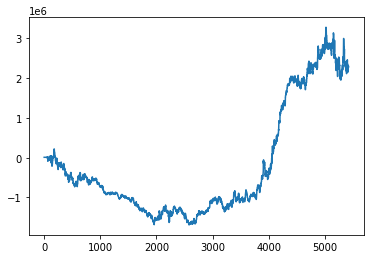

In [21]:
strat = DoubleDifferencing(loreal_hist, AnnualGranularity.H_1.value, stoploss, trade_size=0.3)
strat.apply_strategy(spread=0)
strat.compute_return()
strat.data['return_cumsum'].plot()

In [11]:
strat.granularity = AnnualGranularity.H_1.value
strat.compute_performance()
pd.DataFrame.from_dict(strat.indicators, orient='index')

,0
CAGR,0.13
Volatility,0.13
SharpeRatio,0.96
Calmar,0.07
RiskRewardRatio,0.2
BreakevenHitRatio,83.3
NbTrades,1591
HitRatio,62.3
Expectancy,1.79
ProfitFactor,1.07


In [25]:
strat.indicators['idx_wins_buy']

[67,
 176,
 184,
 204,
 216,
 251,
 264,
 288,
 293,
 307,
 314,
 321,
 369,
 384,
 421,
 494,
 542,
 631,
 667,
 675,
 680,
 699,
 707,
 723,
 747,
 752,
 756,
 764,
 792,
 824,
 836,
 845,
 963,
 1005,
 1036,
 1057,
 1066,
 1116,
 1127,
 1160,
 1245,
 1294,
 1311,
 1325,
 1330,
 1353,
 1435,
 1441,
 1557,
 1574,
 1648,
 1691,
 1701,
 1719,
 1731,
 1737,
 1769,
 1798,
 1881,
 1886,
 1923,
 2023,
 2027,
 2077,
 2116,
 2120,
 2144,
 2167,
 2173,
 2242,
 2248,
 2281,
 2294,
 2314,
 2401,
 2407,
 2416,
 2438,
 2466,
 2473,
 2488,
 2497,
 2507,
 2607,
 2612,
 2617,
 2628,
 2654,
 2693,
 2702,
 2711,
 2743,
 2767,
 2908,
 2925,
 3019,
 3023,
 3034,
 3136,
 3190,
 3207,
 3213,
 3219,
 3223,
 3262,
 3330,
 3335,
 3372,
 3398,
 3459,
 3511,
 3646,
 3671,
 3711,
 3738,
 3826,
 3838,
 3845,
 3871,
 3903,
 3911,
 3939,
 3945,
 3956,
 3967,
 3976,
 3982,
 4045,
 4054,
 4060,
 4072,
 4150,
 4255,
 4299,
 4329,
 4348,
 4378,
 4423,
 4443,
 4463,
 4529,
 4584,
 4612,
 4645,
 4688,
 4697,
 4736,
 4757

In [23]:
strat.data[(strat.data['take_profit'] != 0)]

,table,date,symbol,open,close,low,high,tickqty,delta_pos,delta_neg,wma_span1,wma_span2,diff_wma,delta_hull_pos,delta_hull_neg,rs,hull_rsi,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
51,candle1h,2018-01-04 06:00:00,EUR/USD,1.20199,1.20286,1.20179,1.20387,6775,0.00087,0.00000,0.000058,0.000000,-0.000058,0.000452,-0.000030,-14.838542,107.226195,-1,False,True,1.202860,0.000000,1.205277,1.198026,0.000000,0.00000,10000.000000
52,candle1h,2018-01-04 07:00:00,EUR/USD,1.20286,1.20291,1.20258,1.20384,8803,0.00005,0.00000,0.000032,0.000000,-0.000032,0.000431,-0.000041,-10.519380,110.504886,-1,False,False,1.202910,-0.000050,1.205277,1.198026,-0.000050,-1.50000,9998.500000
53,candle1h,2018-01-04 08:00:00,EUR/USD,1.20291,1.20264,1.20222,1.20359,9515,0.00000,0.00027,0.000093,0.000135,0.000177,0.000173,0.000107,1.621662,61.856254,-1,False,False,1.202640,0.000270,1.205277,1.198026,0.000220,8.10000,10006.600000
54,candle1h,2018-01-04 09:00:00,EUR/USD,1.20264,1.20439,1.20258,1.20467,9380,0.00175,0.00000,0.000064,0.000090,0.000116,0.000768,0.000136,5.644107,84.949069,-1,False,False,1.204390,-0.001750,1.205277,1.198026,-0.001530,-52.50000,9954.100000
55,candle1h,2018-01-04 10:00:00,EUR/USD,1.20439,1.20521,1.20420,1.20565,9862,0.00082,0.00000,0.000051,0.000045,0.000039,0.001194,0.000064,18.580247,94.892812,-1,False,True,1.205277,-0.000887,1.205277,1.198026,-0.002417,-26.60326,9927.496740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18989,candle1h,2020-12-31 10:00:00,EUR/USD,1.22798,1.22803,1.22754,1.22890,16319,0.00006,0.00000,0.000526,0.000737,0.000947,0.000071,0.001151,0.062078,5.844915,-1,True,False,1.228030,-0.000050,1.231903,1.223824,0.001180,-1.50000,12683.868581
18992,candle1h,2020-12-31 13:00:00,EUR/USD,1.22724,1.22851,1.22647,1.22880,10316,0.00127,0.00000,0.000375,0.000182,-0.000012,0.000565,0.000028,20.000000,95.238095,-1,False,True,1.228510,0.000000,1.231500,1.222529,0.000000,0.00000,12683.868581
18993,candle1h,2020-12-31 14:00:00,EUR/USD,1.22852,1.22700,1.22657,1.22860,12083,0.00000,0.00151,0.000664,0.000805,0.000946,0.000651,0.000627,1.039250,50.962374,-1,False,False,1.227000,0.001520,1.231500,1.222529,0.001520,45.60000,12729.468581
18994,candle1h,2020-12-31 15:00:00,EUR/USD,1.22701,1.22393,1.22256,1.22712,24762,0.00000,0.00307,0.001326,0.002038,0.002750,0.000299,0.002149,0.138932,12.198444,-1,False,False,1.223930,0.003080,1.231500,1.222529,0.004600,92.40000,12821.868581


<AxesSubplot:>

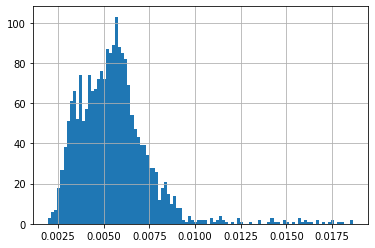

In [20]:
profit_pips = strat.data[(strat.data['ret'] == 0) & (strat.data['take_profit'] != 0)].drop_duplicates(['stop_loss', 'take_profit'])
profit_pips['stop_loss_pips'] = abs(profit_pips['action_price'] - profit_pips['stop_loss'])
profit_pips['take_profit_pips'] = abs(profit_pips['action_price'] - profit_pips['take_profit'])
profit_pips['take_profit_pips'].hist(bins=100, )

<AxesSubplot:>

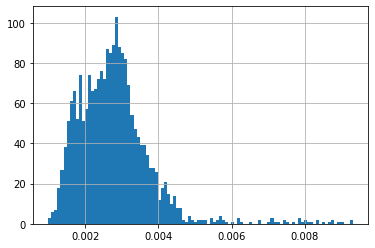

In [21]:
profit_pips['stop_loss_pips'].hist(bins=100)

array([[<AxesSubplot:title={'center':'stop_loss_pips'}>]], dtype=object)

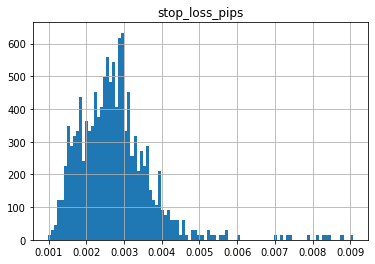

In [34]:
profit_pips.loc[strat.indicators['idx_losses_sell'] + strat.indicators['idx_losses_buy'], ['stop_loss_pips']].hist(bins=100,density=1)

array([[<AxesSubplot:title={'center':'stop_loss_pips'}>]], dtype=object)

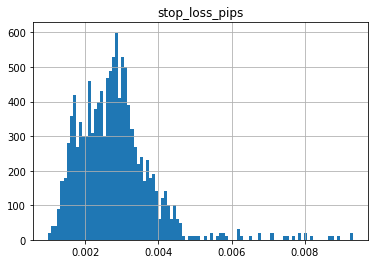

In [35]:
profit_pips.loc[strat.indicators['idx_wins_sell'] + strat.indicators['idx_wins_buy'], ['stop_loss_pips']].hist(bins=100,density=1)

## Hull RSI with MA500 RSI

<AxesSubplot:>

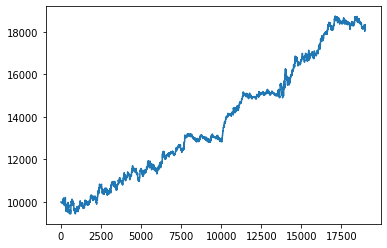

In [38]:
strat1 = HullRSI(candles_EURUSD, AnnualGranularity.H_1.value, stoploss, trade_size=0.3)
strat1.apply_strategy(spread=0)
strat1.compute_return()
strat1.data['return_cumsum'].plot()

<AxesSubplot:>

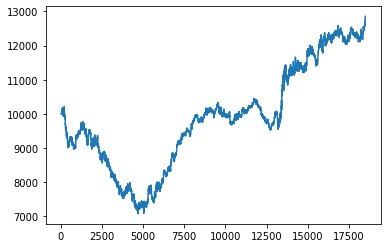

In [41]:
strat2 = MA500Rsi(candles_EURUSD, AnnualGranularity.H_1.value, stoploss, trade_size=0.3)
strat2.apply_strategy(spread=0)
strat2.compute_return()
strat2.data['return_cumsum'].plot()

In [43]:
data1 = strat1.data[['date', 'buy_signal', 'sell_signal']]
data1.columns = ['date', 'buy_signal_1', 'sell_signal_1']

data2 = strat2.data[['date', 'buy_signal', 'sell_signal']]
data2.columns = ['date', 'buy_signal_2', 'sell_signal_2']

data = pd.merge(data1, data2, on='date')

In [65]:
data[(data['sell_signal_1'] > 0) & (data['sell_signal_1'] > 0)].shape

(921, 9)

In [67]:
data[(data['sell_signal_1_roll2'] > 0) & (data['sell_signal_2_roll2'] > 0)].shape

(419, 9)

In [66]:
for col in ['sell_signal_1', 'buy_signal_1', 'sell_signal_2', 'buy_signal_2']:
    data[f'{col}_roll2'] = data[col].rolling(window=2).sum()

In [60]:
data.dropna(inplace=True)

## Several currency pairs

In [21]:

def compute_strategy_for_several_pairs(span=14, stop=2, profit=4, span_loss=50):
    saved_args = locals()
    print(saved_args)
    currencies = ['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CAD', 'USD/CHF']

    #currencies = ['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CHF']
    returns = list()
    perf = list()
    timeframe = 'candle1h'
    for cur in currencies:
        mask = (candles['table'] == timeframe) & (candles['symbol'] == cur)
        candles_tmp = candles[mask]
        stoploss = StopLossATR(stop=stop, profit=profit, span=span_loss, update=False)
        strat = DoubleDifferencing(candles_tmp, AnnualGranularity.H_1.value, stoploss, trade_size=0.1, init_investment=10000)
        strat.apply_strategy(spread=0)
        strat.compute_return()
        returns.append(strat.data['return_cumsum'])

        strat.compute_performance()
        perf.append(strat.indicators)
    
    plt.figure(figsize=(20,10))
    for cur, data in zip(currencies, returns):
        plt.plot(data, label=cur)
    plt.legend(loc="upper left")
    plt.show()
    
    plt.figure(figsize=(20,10))
    plt.plot(pd.DataFrame(returns).dropna(axis=1).sum(axis=0))
    plt.title('Sum of all currency pairs')
    plt.show()
    
    indicators = pd.DataFrame(perf, index=currencies)
    indicators = indicators[[x for x in indicators.columns if not x.startswith('idx')]]
    display(indicators)

In [22]:
params = {'span': [14],
          'stop': [5],
          'profit': [1]}

{'span': 14, 'stop': 5, 'profit': 1, 'span_loss': 50}


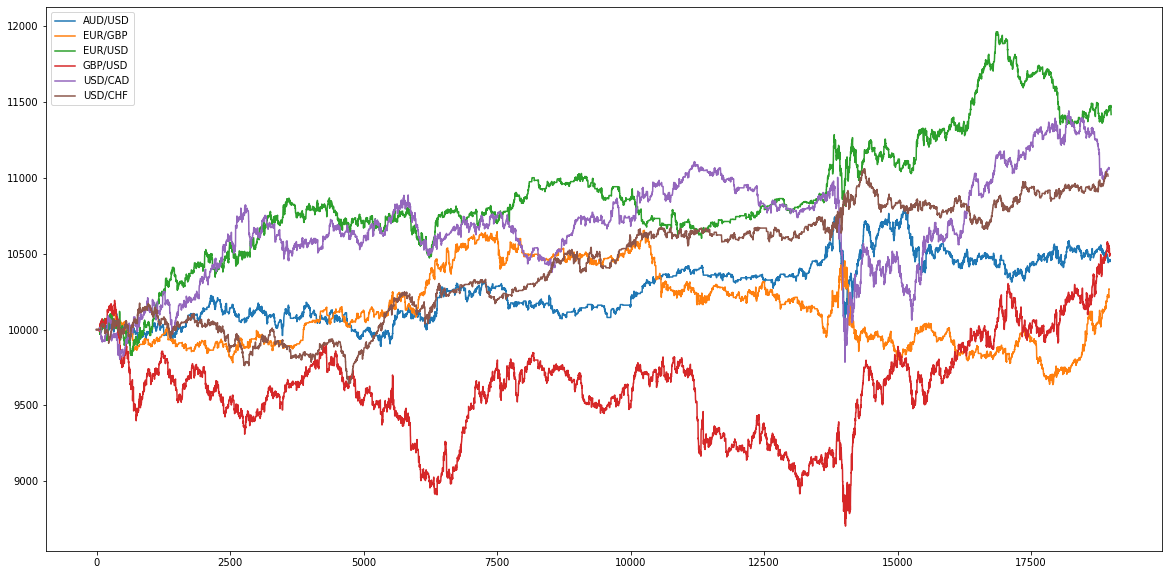

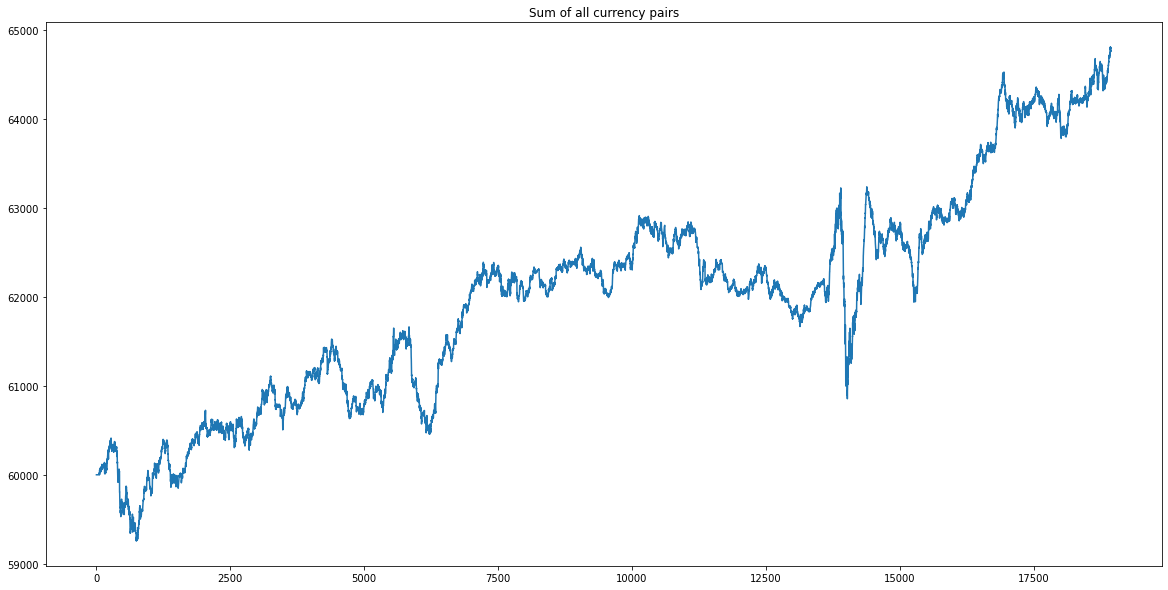

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.01,0.05,0.10,-0.00,0.2,83.3,1361,62.0,-0.19,0.98,12.4,20.7
EUR/GBP,0.01,0.05,0.10,0.00,0.2,83.3,1362,62.6,-0.10,0.99,12.4,21.0
EUR/USD,0.04,0.05,0.70,0.07,0.2,83.3,1594,62.1,0.54,1.07,14.0,21.6
GBP/USD,0.02,0.09,0.17,0.00,0.2,83.3,2242,59.9,-0.52,0.95,17.3,27.1
USD/CAD,0.03,0.06,0.42,0.07,0.2,83.3,1824,62.0,-0.02,1.00,14.6,23.8
USD/CHF,0.03,0.04,0.62,-0.21,0.2,83.3,1349,65.1,0.40,1.06,11.3,19.9


In [23]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 14, 'stop': 5, 'profit': 1, 'span_loss': 50}


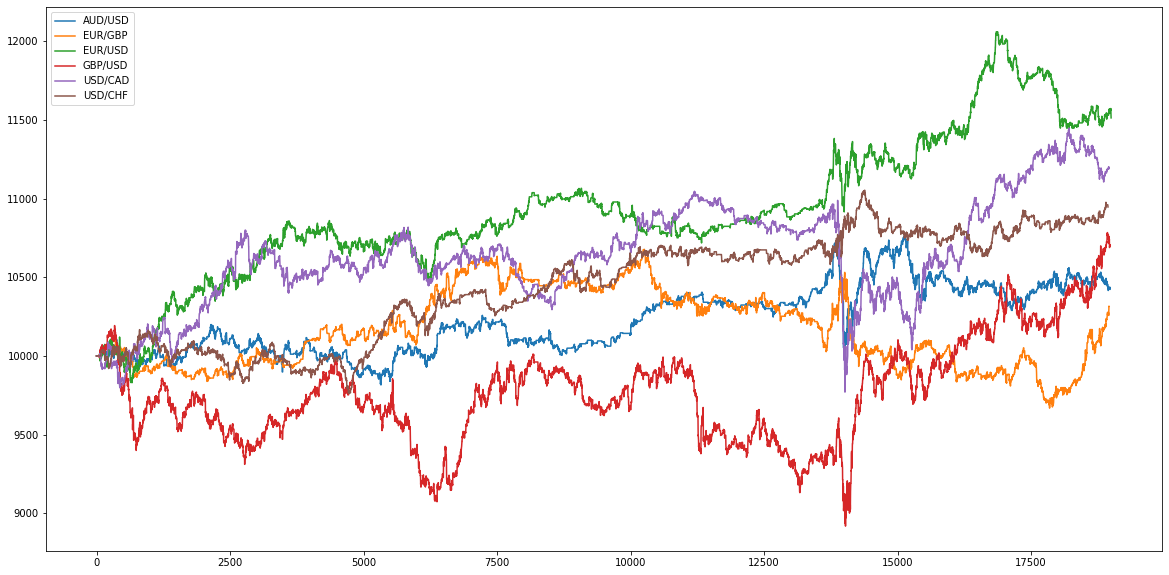

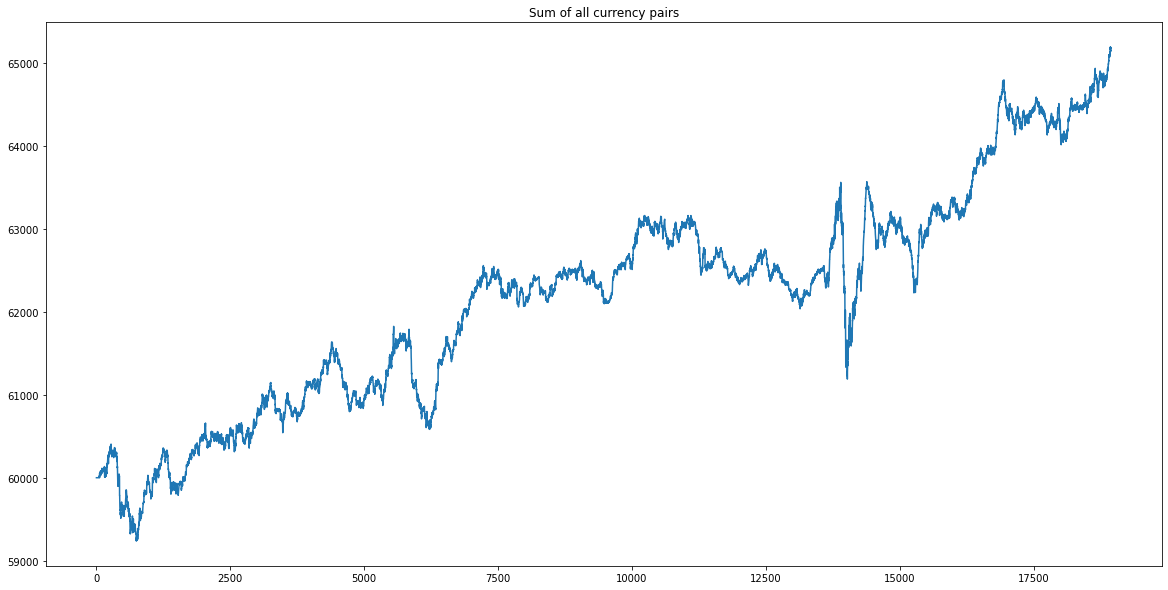

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.01,0.05,0.10,-0.00,0.2,83.3,1358,61.9,-0.16,0.98,12.4,20.5
EUR/GBP,0.01,0.05,0.10,0.00,0.2,83.3,1352,62.6,-0.09,0.99,12.4,21.1
EUR/USD,0.05,0.05,0.90,0.07,0.2,83.3,1591,62.3,0.60,1.07,14.0,21.5
GBP/USD,0.02,0.08,0.19,0.00,0.2,83.3,2240,60.0,-0.43,0.96,17.3,26.9
USD/CAD,0.04,0.06,0.58,0.07,0.2,83.3,1822,62.2,0.07,1.01,14.5,23.7
USD/CHF,0.03,0.04,0.62,-0.21,0.2,83.3,1339,64.9,0.36,1.05,11.2,19.8


In [20]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 14, 'stop': 2, 'profit': 8, 'span_loss': 50}


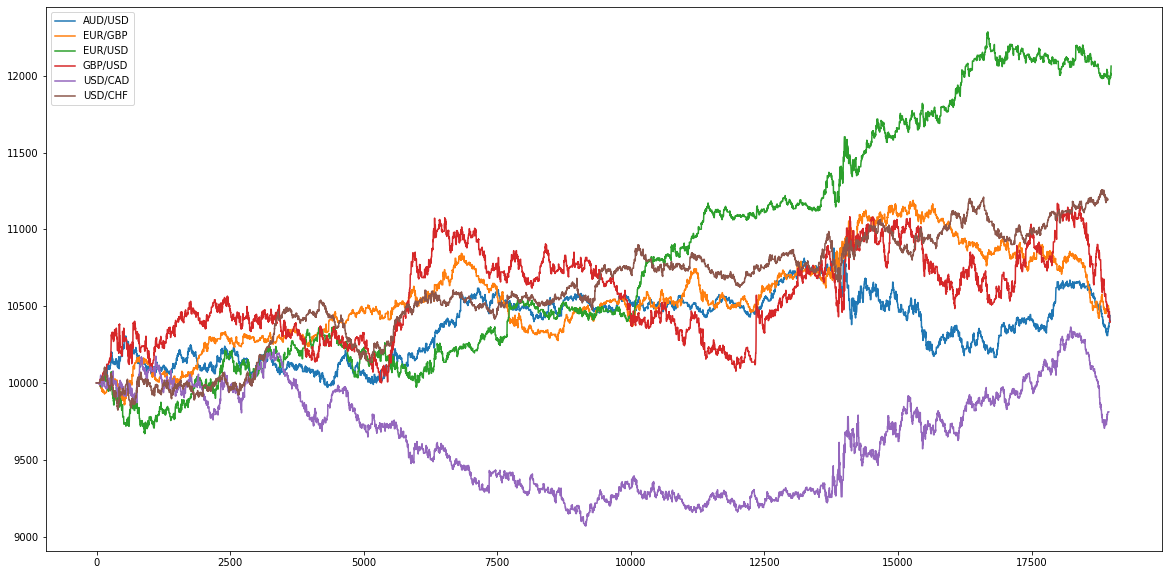

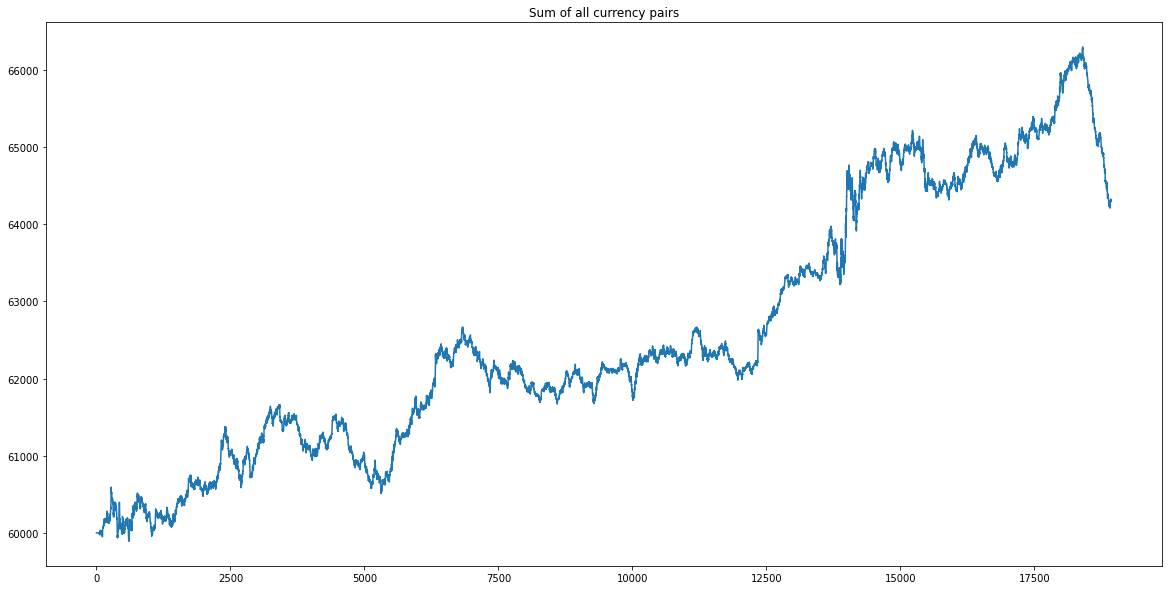

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.01,0.05,0.10,-0.00,4.0,20.0,903,50.7,0.25,1.02,22.0,22.2
EUR/GBP,0.02,0.04,0.38,0.00,4.0,20.0,1007,53.4,0.21,1.02,17.6,19.8
EUR/USD,0.06,0.05,1.10,0.00,4.0,20.0,970,54.8,1.72,1.17,22.1,23.0
GBP/USD,0.01,0.07,0.07,0.00,4.0,20.0,993,52.5,-0.13,0.99,31.1,34.6
USD/CAD,-0.01,0.06,-0.25,0.07,4.0,20.0,927,51.7,-0.59,0.95,23.8,26.7
USD/CHF,0.04,0.04,0.88,-0.21,4.0,20.0,907,55.3,1.05,1.12,18.3,20.3


In [106]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 14, 'stop': 3, 'profit': 9, 'span_loss': 50}


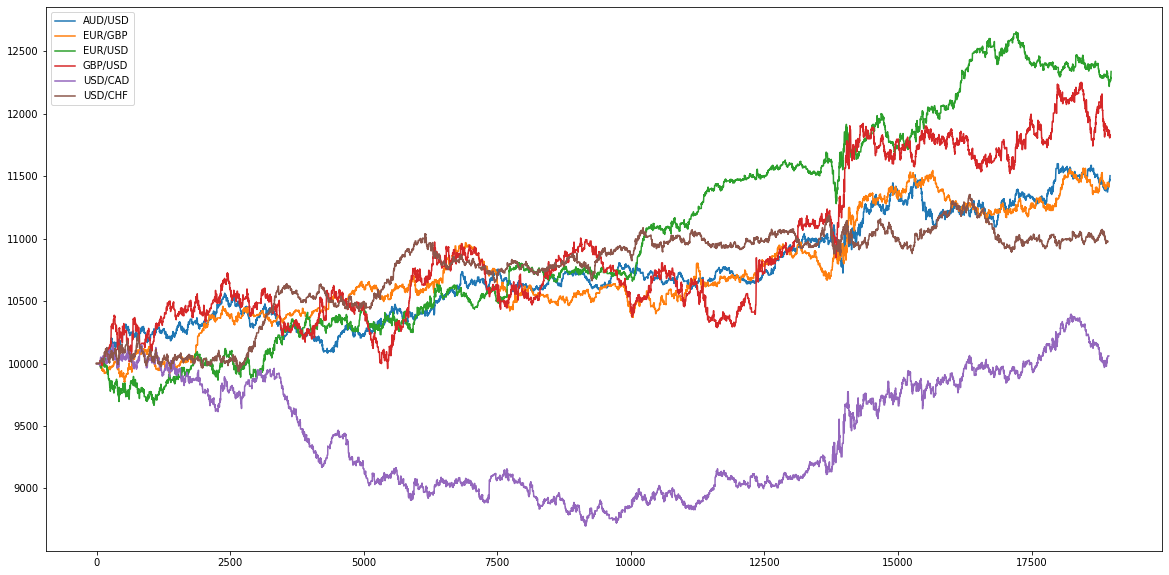

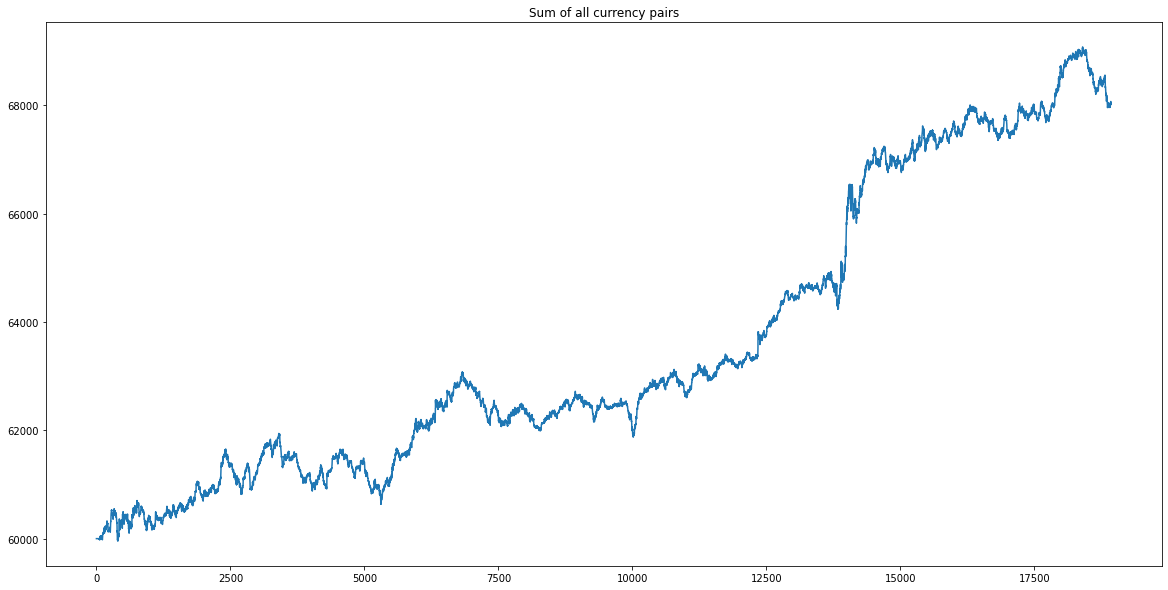

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.05,0.05,0.90,-0.00,3.0,25.0,814,59.1,1.58,1.14,21.6,27.3
EUR/GBP,0.04,0.04,0.88,0.00,3.0,25.0,907,59.2,1.31,1.14,18.4,23.5
EUR/USD,0.07,0.05,1.30,0.00,3.0,25.0,884,60.4,2.38,1.22,22.1,27.6
GBP/USD,0.05,0.08,0.56,0.00,3.0,25.0,891,59.1,1.57,1.09,32.2,42.8
USD/CAD,0.00,0.07,-0.07,0.07,3.0,25.0,839,57.8,-0.14,0.99,22.9,31.7
USD/CHF,0.03,0.04,0.62,-0.21,3.0,25.0,810,59.8,1.03,1.10,18.6,25.0


In [104]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 6, 'stop': 2, 'profit': 4, 'span_loss': 50}


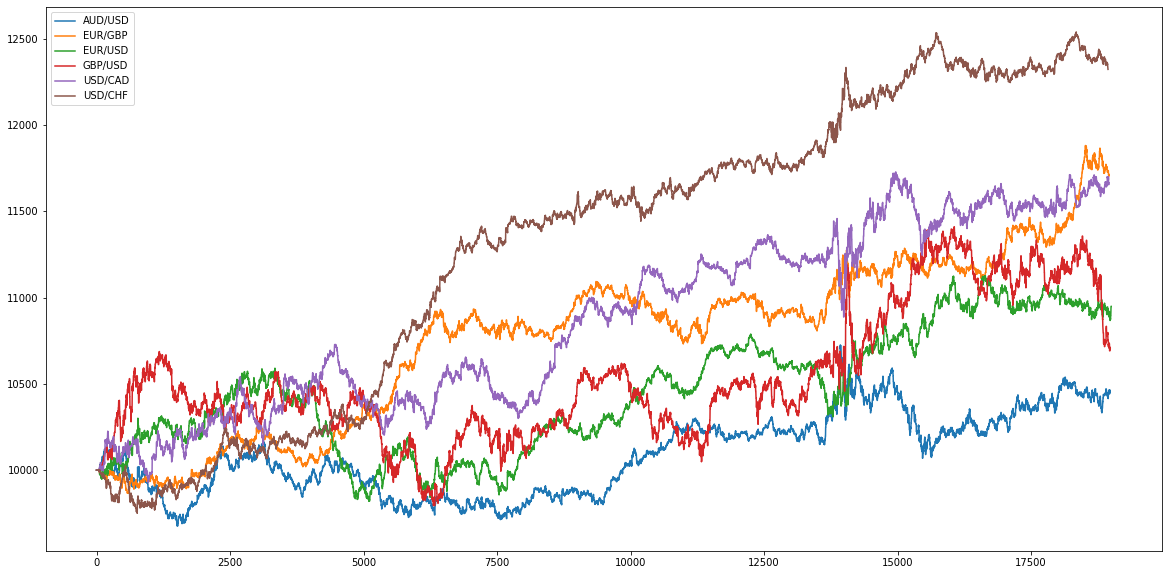

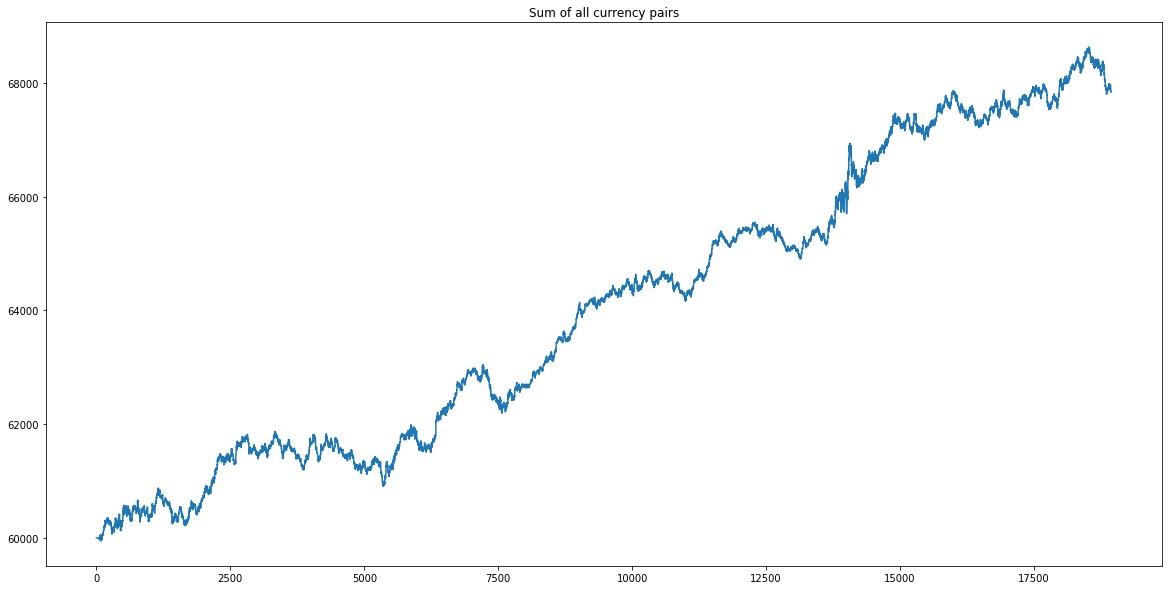

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.01,0.05,0.10,-0.03,2.0,33.3,2008,58.7,-0.06,0.99,11.5,16.5
EUR/GBP,0.05,0.04,1.12,0.00,2.0,33.3,2037,60.7,0.50,1.08,10.8,15.3
EUR/USD,0.03,0.05,0.50,0.07,2.0,33.3,2024,59.4,0.18,1.02,12.8,18.3
GBP/USD,0.02,0.07,0.21,0.00,2.0,33.3,2035,58.2,-0.20,0.98,19.4,27.4
USD/CAD,0.05,0.06,0.75,0.07,2.0,33.3,2019,59.2,0.52,1.06,15.2,20.9
USD/CHF,0.07,0.04,1.62,-0.21,2.0,33.3,2028,60.3,0.83,1.14,11.0,14.6


In [10]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 6, 'stop': 2, 'profit': 4, 'span_loss': 50}


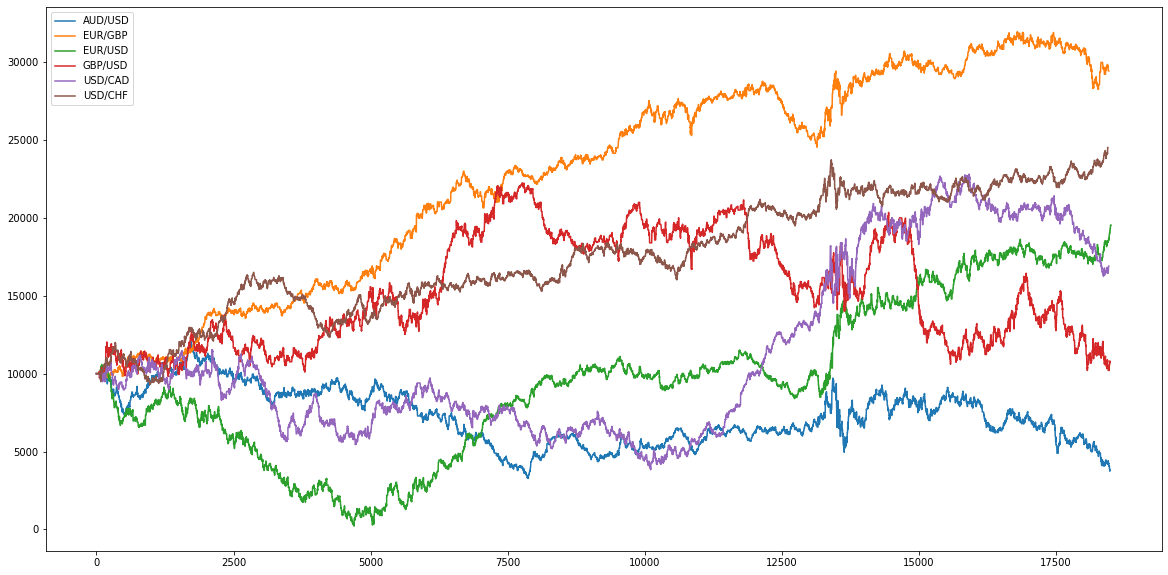

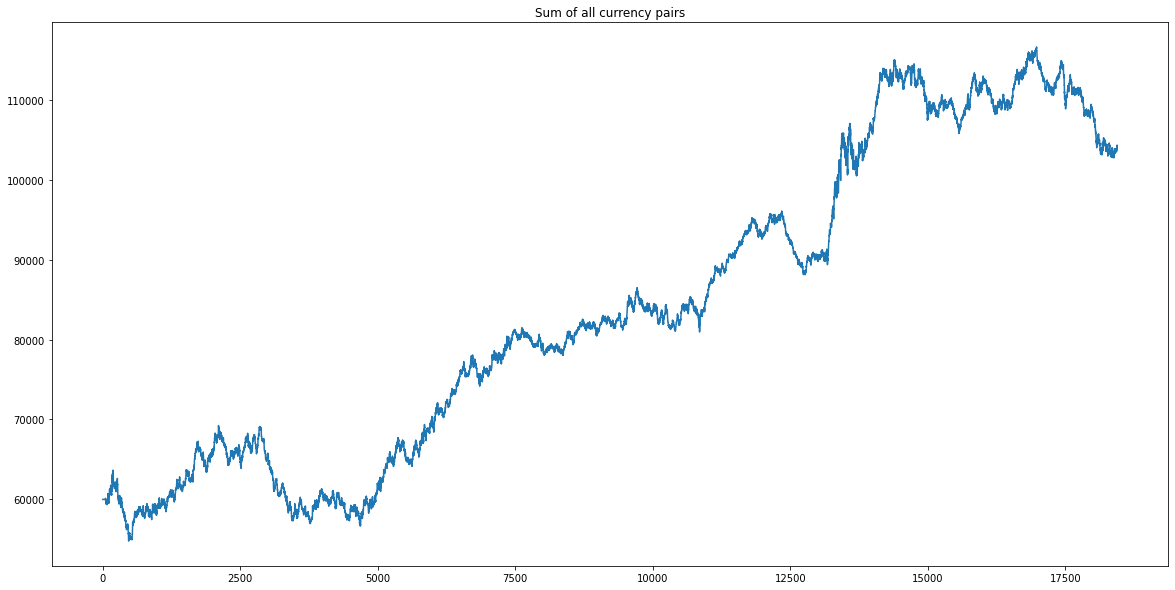

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,-0.27,0.63,-0.44,-0.06,2.0,33.3,1226,59.3,-9.10,0.90,14.2,23.0
EUR/GBP,0.42,0.20,2.07,0.09,2.0,33.3,1189,63.4,11.79,1.15,14.0,21.0
EUR/USD,0.24,2.03,0.12,-0.07,2.0,33.3,1229,60.5,2.70,1.03,16.3,24.3
GBP/USD,0.02,0.51,0.03,-0.05,2.0,33.3,1164,59.0,-8.93,0.94,24.6,37.6
USD/CAD,0.19,0.59,0.31,0.07,2.0,33.3,1211,61.1,-1.55,0.99,18.4,29.4
USD/CHF,0.34,0.24,1.40,-0.14,2.0,33.3,1215,62.7,6.82,1.09,13.2,20.4


In [43]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 6, 'stop': 2, 'profit': 4, 'span_loss': 50}


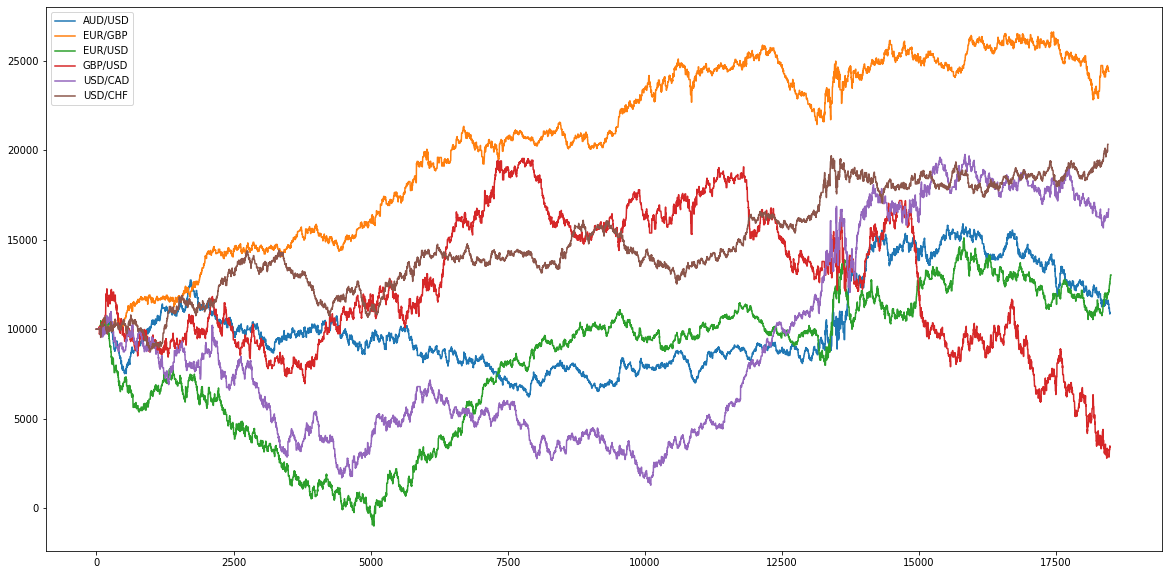

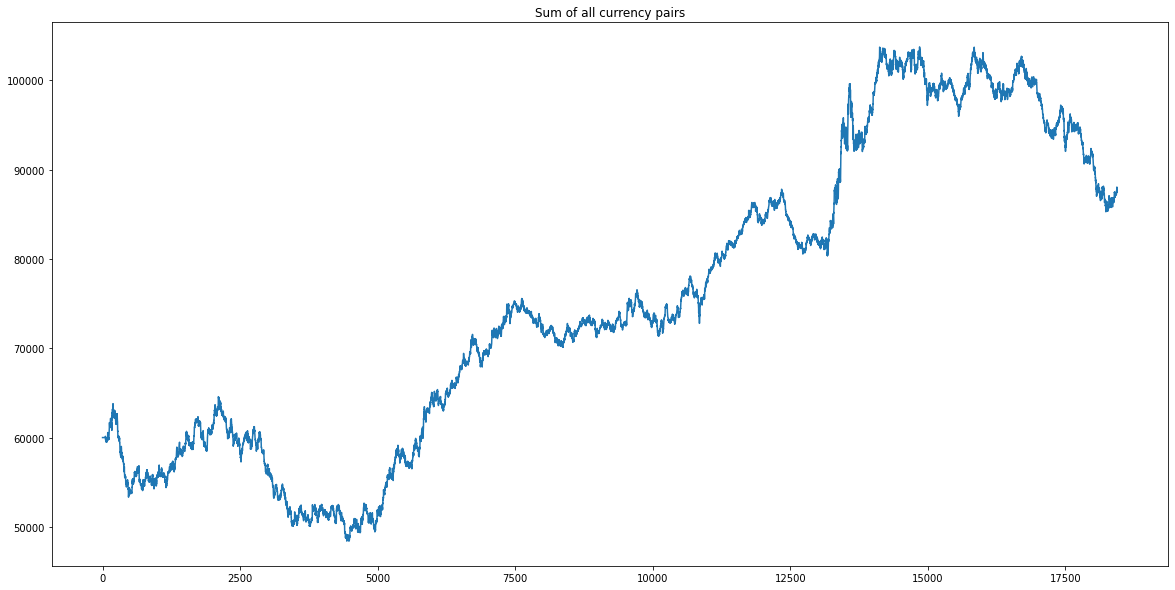

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.03,0.42,0.06,-0.06,2.0,33.3,1275,56.0,-2.72,0.97,14.8,19.4
EUR/GBP,0.34,0.21,1.60,0.09,2.0,33.3,1235,59.1,7.32,1.10,14.1,18.7
EUR/USD,0.09,91.94,0.00,-0.07,2.0,33.3,1281,57.0,-2.03,0.98,16.4,22.2
GBP/USD,-0.30,0.70,-0.44,-0.05,2.0,33.3,1211,54.9,-14.64,0.90,24.8,33.4
USD/CAD,0.18,0.95,0.18,0.07,2.0,33.3,1271,57.0,-0.80,0.99,19.1,25.5
USD/CHF,0.26,0.27,0.94,-0.14,2.0,33.3,1260,59.3,3.60,1.05,13.2,18.4


In [6]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

{'span': 6, 'stop': 1, 'profit': 4, 'span_loss': 50}


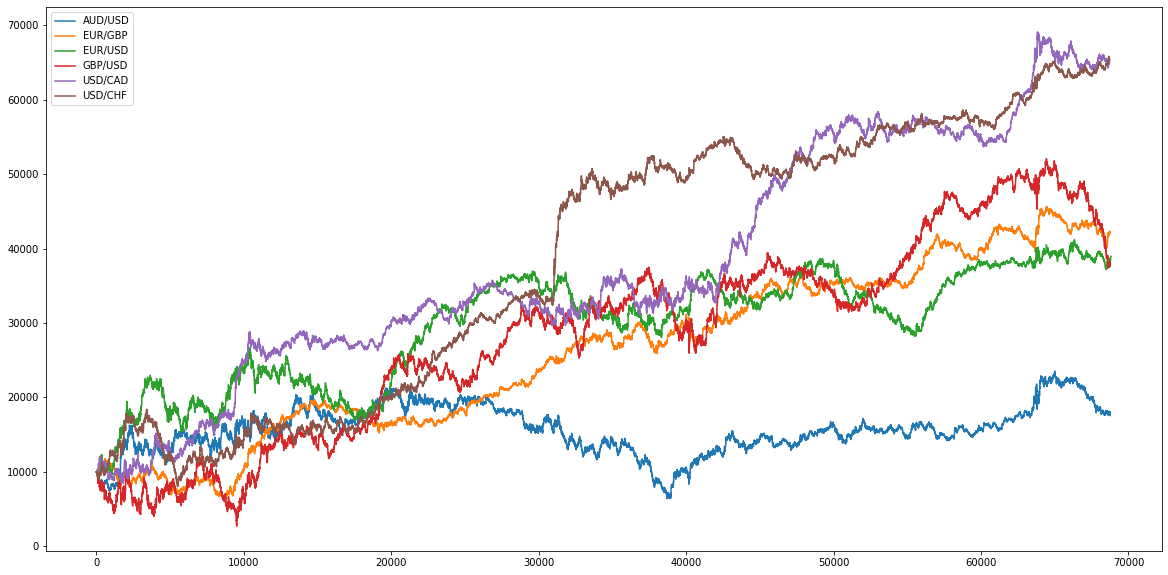

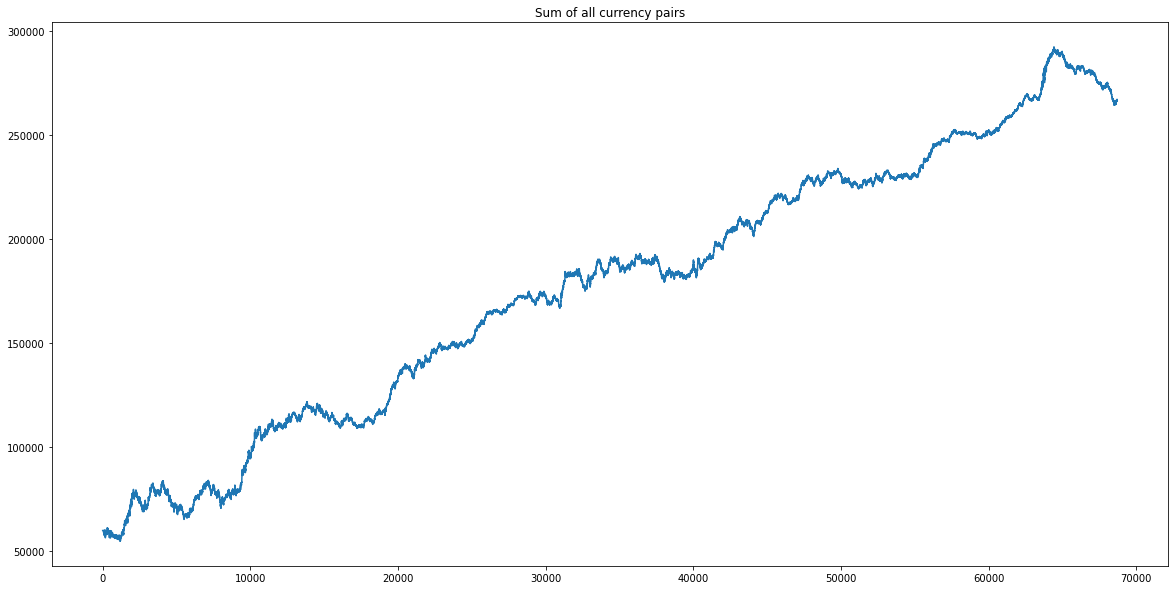

,CAGR,Volatility,SharpeRatio,Calmar,RiskRewardRatio,BreakevenHitRatio,NbTrades,HitRatio,Expectancy,ProfitFactor,MeanWinsPips,MeanLossesPips
AUD/USD,0.05,0.34,0.13,-0.02,4.0,20.0,5475,42.2,-3.17,0.97,21.8,16.5
EUR/GBP,0.13,0.22,0.57,0.00,4.0,20.0,5282,45.2,3.06,1.05,15.4,12.1
EUR/USD,0.13,0.24,0.52,-0.03,4.0,20.0,5327,43.6,0.64,1.01,23.8,18.3
GBP/USD,0.13,0.52,0.24,-0.03,4.0,20.0,5241,43.6,-1.52,0.99,28.2,22.1
USD/CAD,0.18,0.22,0.80,0.11,4.0,20.0,5379,44.2,5.75,1.06,22.1,16.5
USD/CHF,0.18,0.23,0.76,-0.05,4.0,20.0,5389,46.0,6.76,1.08,18.9,14.9


In [39]:
for span in params['span']:
    for stop in params['stop']:
        for profit in params['profit']:
            compute_strategy_for_several_pairs(span, stop, profit)

In [26]:
300000 * 1e-4

30.0

In [27]:
6 * 7500 * 2 * 30

2700000

# Show some data

In [24]:
strat.data.loc[65:85, :]

,table,date,symbol,open,close,low,high,tickqty,delta_pos,delta_neg,wma_span1,wma_span2,diff_wma,delta_hull_pos,delta_hull_neg,rs,hull_rsi,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
65,candle1h,2018-01-05 05:00:00,EUR/USD,1.20747,1.20722,1.20704,1.20762,3634,0.00000,0.00025,0.000196,0.000169,0.000141,0.000140,0.000121,1.158671,53.675193,0,False,False,1.207220,0.000000,0.000000,0.000000,0.000000,0.00000,10000.00000
66,candle1h,2018-01-05 06:00:00,EUR/USD,1.20722,1.20573,1.20573,1.20751,5439,0.00000,0.00149,0.000358,0.000489,0.000619,0.000063,0.000373,0.168431,14.415170,0,False,False,1.205730,0.000000,0.000000,0.000000,0.000000,0.00000,10000.00000
67,candle1h,2018-01-05 07:00:00,EUR/USD,1.20573,1.20581,1.20561,1.20679,8683,0.00008,0.00000,0.000318,0.000401,0.000485,0.000005,0.000472,0.010251,1.014688,1,True,False,1.205810,0.000000,1.203414,1.210602,0.000000,0.00000,10000.00000
68,candle1h,2018-01-05 08:00:00,EUR/USD,1.20581,1.20535,1.20518,1.20630,10102,0.00000,0.00046,0.000338,0.000429,0.000519,-0.000024,0.000524,-0.045386,-4.754351,1,False,False,1.205350,-0.000460,1.203414,1.210602,-0.000460,-4.60000,9995.40000
69,candle1h,2018-01-05 09:00:00,EUR/USD,1.20535,1.20463,1.20423,1.20583,7895,0.00000,0.00072,0.000399,0.000523,0.000647,-0.000037,0.000577,-0.064191,-6.859375,1,False,False,1.204630,-0.000720,1.203414,1.210602,-0.001180,-7.20000,9988.20000
70,candle1h,2018-01-05 10:00:00,EUR/USD,1.20463,1.20506,1.20431,1.20548,9180,0.00043,0.00000,0.000357,0.000416,0.000476,0.000030,0.000540,0.056321,5.331795,1,False,False,1.205060,0.000430,1.203414,1.210602,-0.000750,4.30000,9992.50000
71,candle1h,2018-01-05 11:00:00,EUR/USD,1.20506,1.20534,1.20489,1.20560,5500,0.00028,0.00000,0.000317,0.000310,0.000302,0.000121,0.000418,0.288947,22.417275,1,False,False,1.205340,0.000280,1.203414,1.210602,-0.000470,2.80000,9995.30000
72,candle1h,2018-01-05 12:00:00,EUR/USD,1.20534,1.20483,1.20452,1.20549,6438,0.00000,0.00051,0.000346,0.000333,0.000320,0.000158,0.000340,0.463876,31.688187,1,False,False,1.204830,-0.000510,1.203414,1.210602,-0.000980,-5.10000,9990.20000
73,candle1h,2018-01-05 13:00:00,EUR/USD,1.20483,1.20526,1.20454,1.20838,31770,0.00043,0.00000,0.000301,0.000219,0.000137,0.000223,0.000226,0.988179,49.702729,1,False,False,1.205260,0.000430,1.203414,1.210602,-0.000550,4.30000,9994.50000
74,candle1h,2018-01-05 14:00:00,EUR/USD,1.20526,1.20307,1.20256,1.20566,23466,0.00000,0.00219,0.000554,0.000706,0.000859,0.000227,0.000528,0.430468,30.092806,1,False,False,1.203414,-0.001846,1.203414,1.210602,-0.002396,-18.46135,9976.03865


In [21]:
strat.data[(strat.data['action'] == 1)]

,table,date,symbol,open,close,low,high,tickqty,delta_pos,delta_neg,wma_span1,wma_span2,diff_wma,delta_hull_pos,delta_hull_neg,rs,hull_rsi,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
67,candle1h,2018-01-05 07:00:00,EUR/USD,1.20573,1.20581,1.20561,1.20679,8683,0.00008,0.00000,0.000318,0.000401,0.000485,0.000005,0.000472,0.010251,1.014688,1,True,False,1.20581,0.00000,1.203414,1.210602,0.00000,0.0,10000.000000
68,candle1h,2018-01-05 08:00:00,EUR/USD,1.20581,1.20535,1.20518,1.20630,10102,0.00000,0.00046,0.000338,0.000429,0.000519,-0.000024,0.000524,-0.045386,-4.754351,1,False,False,1.20535,-0.00046,1.203414,1.210602,-0.00046,-4.6,9995.400000
69,candle1h,2018-01-05 09:00:00,EUR/USD,1.20535,1.20463,1.20423,1.20583,7895,0.00000,0.00072,0.000399,0.000523,0.000647,-0.000037,0.000577,-0.064191,-6.859375,1,False,False,1.20463,-0.00072,1.203414,1.210602,-0.00118,-7.2,9988.200000
70,candle1h,2018-01-05 10:00:00,EUR/USD,1.20463,1.20506,1.20431,1.20548,9180,0.00043,0.00000,0.000357,0.000416,0.000476,0.000030,0.000540,0.056321,5.331795,1,False,False,1.20506,0.00043,1.203414,1.210602,-0.00075,4.3,9992.500000
71,candle1h,2018-01-05 11:00:00,EUR/USD,1.20506,1.20534,1.20489,1.20560,5500,0.00028,0.00000,0.000317,0.000310,0.000302,0.000121,0.000418,0.288947,22.417275,1,False,False,1.20534,0.00028,1.203414,1.210602,-0.00047,2.8,9995.300000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18959,candle1h,2020-12-30 13:00:00,EUR/USD,1.22904,1.22918,1.22772,1.22920,13635,0.00015,0.00000,0.000295,0.000216,0.000137,0.000774,0.000261,2.963104,74.767250,1,False,False,1.22918,0.00014,1.224088,1.232254,0.00236,1.4,12707.044152
18960,candle1h,2020-12-30 14:00:00,EUR/USD,1.22918,1.22975,1.22718,1.23106,24467,0.00057,0.00000,0.000258,0.000114,-0.000031,0.000822,0.000084,9.764024,90.709794,1,False,True,1.22975,0.00057,1.224088,1.232254,0.00293,5.7,12712.744152
18987,candle1h,2020-12-31 17:00:00,EUR/USD,1.22307,1.22255,1.22223,1.22351,11657,0.00000,0.00053,0.000878,0.001117,0.001357,0.000140,0.001462,0.095567,8.723096,1,True,False,1.22255,0.00000,1.219279,1.229093,0.00000,0.0,12780.744152
18988,candle1h,2020-12-31 18:00:00,EUR/USD,1.22255,1.22176,1.22156,1.22289,6998,0.00000,0.00079,0.000894,0.001074,0.001254,0.000074,0.001333,0.055577,5.265088,1,False,False,1.22176,-0.00079,1.219279,1.229093,-0.00079,-7.9,12772.844152


In [21]:
strat.data[170:200]

,table,date,symbol,open,close,low,high,tickqty,rsi_1,rsi_2,rsi_3,action,buy_signal,sell_signal,action_price,ret,stop_loss,take_profit,current_returns,return,return_cumsum
170,candle1h,2018-01-11 11:00:00,EUR/USD,1.19472,1.19442,1.19413,1.19514,8930,41.372949,50.775822,51.839273,0,False,False,1.194420,0.000000,0.000000,0.000000,0.000000,0.000000,10088.693574
171,candle1h,2018-01-11 12:00:00,EUR/USD,1.19442,1.20050,1.19372,1.20137,38073,85.987000,78.447980,71.469577,-1,False,True,1.200500,0.000000,1.203978,1.193544,0.000000,0.000000,10088.693574
172,candle1h,2018-01-11 13:00:00,EUR/USD,1.20050,1.20321,1.20031,1.20360,41434,90.159298,79.776978,72.151028,-1,False,False,1.203210,-0.002710,1.203978,1.193544,-0.002710,-27.100000,10061.593574
173,candle1h,2018-01-11 14:00:00,EUR/USD,1.20321,1.20484,1.20316,1.20495,22056,91.959278,80.427824,72.552352,-1,False,False,1.203978,-0.000768,1.203978,1.193544,-0.003478,-7.681522,10053.912052
174,candle1h,2018-01-11 15:00:00,EUR/USD,1.20484,1.20495,1.20401,1.20596,23238,92.081459,80.481124,72.592782,0,False,False,1.204950,0.000000,0.000000,0.000000,0.000000,0.000000,10053.912052
175,candle1h,2018-01-11 16:00:00,EUR/USD,1.20495,1.20351,1.20326,1.20505,14189,73.744873,53.267741,37.417189,0,False,False,1.203510,0.000000,0.000000,0.000000,0.000000,0.000000,10053.912052
176,candle1h,2018-01-11 17:00:00,EUR/USD,1.20351,1.20382,1.20319,1.20417,8092,75.080237,54.663242,39.302471,0,False,False,1.203820,0.000000,0.000000,0.000000,0.000000,0.000000,10053.912052
177,candle1h,2018-01-11 18:00:00,EUR/USD,1.20382,1.20375,1.20308,1.20483,9817,74.017644,53.086450,37.698488,0,False,False,1.203750,0.000000,0.000000,0.000000,0.000000,0.000000,10053.912052
178,candle1h,2018-01-11 19:00:00,EUR/USD,1.20375,1.20398,1.20347,1.20465,5829,75.444965,55.253661,41.780596,0,False,False,1.203980,0.000000,0.000000,0.000000,0.000000,0.000000,10053.912052
179,candle1h,2018-01-11 20:00:00,EUR/USD,1.20398,1.20314,1.20282,1.20407,4066,60.318008,34.276721,23.305297,1,True,False,1.203140,0.000000,1.199683,1.210055,0.000000,0.000000,10053.912052


In [223]:
strat.[data.tail(20)]

,table,date,symbol,open,close,low,high,tickqty,ma_high,ma_low,action,action_price,ret,stop_loss,take_profit
68589,candle1h,2020-12-31 00:00:00,EUR/USD,1.22992,1.23072,1.22956,1.23090,4298,1.210024,1.208631,0,1.23072,0.0,0.0,0.0
68590,candle1h,2020-12-31 01:00:00,EUR/USD,1.23072,1.23073,1.22998,1.23100,6110,1.210092,1.208700,0,1.23073,0.0,0.0,0.0
68591,candle1h,2020-12-31 02:00:00,EUR/USD,1.23073,1.22902,1.22862,1.23099,5933,1.210160,1.208766,0,1.22902,0.0,0.0,0.0
68592,candle1h,2020-12-31 03:00:00,EUR/USD,1.22903,1.22917,1.22872,1.22946,5045,1.210224,1.208831,0,1.22917,0.0,0.0,0.0
68593,candle1h,2020-12-31 04:00:00,EUR/USD,1.22916,1.22873,1.22859,1.22919,3225,1.210289,1.208897,0,1.22873,0.0,0.0,0.0
68594,candle1h,2020-12-31 05:00:00,EUR/USD,1.22872,1.22902,1.22860,1.22979,3925,1.210355,1.208963,0,1.22902,0.0,0.0,0.0
68595,candle1h,2020-12-31 06:00:00,EUR/USD,1.22902,1.22921,1.22868,1.22935,3986,1.210419,1.209029,0,1.22921,0.0,0.0,0.0
68596,candle1h,2020-12-31 07:00:00,EUR/USD,1.22922,1.22973,1.22916,1.23038,8604,1.210485,1.209094,0,1.22973,0.0,0.0,0.0
68597,candle1h,2020-12-31 08:00:00,EUR/USD,1.22972,1.23018,1.22877,1.23047,13456,1.210550,1.209158,0,1.23018,0.0,0.0,0.0
68598,candle1h,2020-12-31 09:00:00,EUR/USD,1.23017,1.22797,1.22775,1.23020,17614,1.210613,1.209219,0,1.22797,0.0,0.0,0.0


In [14]:
strat.data.loc[:20, ['close', 'low', 'high', 'hist_macd', 'action', 'stop_loss', 'take_profit', 'ret', 'return_cumsum']]

,close,low,high,hist_macd,action,stop_loss,take_profit,ret,return_cumsum
0,1.13007,1.12817,1.13089,-4.818364e-04,0,0.00000,0.00000,0.00000,10000.0
1,1.12770,1.12688,1.13164,-6.256687e-04,0,0.00000,0.00000,0.00000,10000.0
2,1.12893,1.12763,1.13193,-6.314974e-04,0,0.00000,0.00000,0.00000,10000.0
3,1.12978,1.12861,1.13092,-5.728108e-04,0,0.00000,0.00000,0.00000,10000.0
4,1.13047,1.12902,1.13058,-4.850376e-04,0,0.00000,0.00000,0.00000,10000.0
5,1.12879,1.12847,1.13156,-5.248817e-04,0,0.00000,0.00000,0.00000,10000.0
6,1.12674,1.12558,1.12968,-6.634062e-04,0,0.00000,0.00000,0.00000,10000.0
7,1.12825,1.12415,1.12852,-6.384372e-04,0,0.00000,0.00000,0.00000,10000.0
8,1.13481,1.12802,1.13643,-2.024143e-04,0,0.00000,0.00000,0.00000,10000.0
9,1.13372,1.13333,1.13549,-4.350403e-07,0,0.00000,0.00000,0.00000,10000.0


In [60]:
strat.data['%50'] = strat.data.apply(axis=1, func=lambda x: int(x['return_cumsum'] % 50))

In [ ]:
strat.data

In [9]:
mask = (strat.data['high'] >= strat.data['previous_roll_max'])
strat.data[mask]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
949606,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308,0.005080,1.10536,1.07785,418308.0,candle1d,2020-02-27,EUR/USD,1.08870,1.09970,1.08854,1.10072,331934.0,0.004841,1.10486,1.07785,331934.0,0
949607,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988,0.005054,1.10745,1.07785,418308.0,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308.0,0.005080,1.10536,1.07785,418308.0,0
949608,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031,0.005580,1.11853,1.07785,486031.0,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988.0,0.005054,1.10745,1.07785,418308.0,0
949609,candle1d,2020-03-03,EUR/USD,1.11449,1.11772,1.10958,1.12140,509082,0.006132,1.12140,1.07785,509082.0,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031.0,0.005580,1.11853,1.07785,486031.0,0
949611,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027,0.006802,1.12458,1.07785,509082.0,candle1d,2020-03-04,EUR/USD,1.11772,1.11390,1.10961,1.11881,342226.0,0.006343,1.12140,1.07785,509082.0,0
949612,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869,0.007220,1.13553,1.07785,580869.0,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027.0,0.006802,1.12458,1.07785,509082.0,0
949613,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591,0.007488,1.13974,1.07785,580869.0,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869.0,0.007220,1.13553,1.07785,580869.0,0
949614,candle1d,2020-03-09,EUR/USD,1.13884,1.13999,1.13568,1.14974,956742,0.008021,1.14974,1.07785,956742.0,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591.0,0.007488,1.13974,1.07785,580869.0,0
949660,candle1d,2020-05-01,EUR/USD,1.09456,1.09846,1.09352,1.10196,222060,0.007317,1.10196,1.07276,390717.0,candle1d,2020-04-30,EUR/USD,1.08779,1.09456,1.08335,1.09735,390717.0,0.007230,1.09922,1.07276,390717.0,0
949682,candle1d,2020-05-27,EUR/USD,1.09791,1.10174,1.09343,1.10315,420202,0.006810,1.10315,1.07672,420202.0,candle1d,2020-05-26,EUR/USD,1.09023,1.09791,1.08973,1.09966,241409.0,0.006650,1.10091,1.07672,292042.0,0


In [18]:
strat.data[strat.data['action'] != 0]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
148323,candle,2020-01-03 07:15:00,EUR/USD,1.11639,1.11614,1.11607,1.11650,1168,0.000228,1.11722,1.11607,1381.0,candle,2020-01-03 07:10:00,EUR/USD,1.11713,1.11639,1.11637,1.11720,1381.0,0.000220,1.11722,1.11637,1381.0,-1
148333,candle,2020-01-03 08:05:00,EUR/USD,1.11570,1.11577,1.11566,1.11587,944,0.000307,1.11722,1.11526,2158.0,candle,2020-01-03 08:00:00,EUR/USD,1.11539,1.11570,1.11526,1.11595,2158.0,0.000306,1.11722,1.11526,2158.0,1
148417,candle,2020-01-03 15:05:00,EUR/USD,1.11565,1.11591,1.11541,1.11608,1933,0.000426,1.11679,1.11359,4124.0,candle,2020-01-03 15:00:00,EUR/USD,1.11529,1.11565,1.11529,1.11679,4124.0,0.000400,1.11679,1.11359,4124.0,1
148464,candle,2020-01-03 19:00:00,EUR/USD,1.11679,1.11656,1.11651,1.11689,1080,0.000237,1.11742,1.11651,1408.0,candle,2020-01-03 18:55:00,EUR/USD,1.11689,1.11679,1.11666,1.11694,459.0,0.000231,1.11742,1.11666,1408.0,-1
148826,candle,2020-01-07 00:05:00,EUR/USD,1.11944,1.11956,1.11944,1.11960,420,0.000112,1.11982,1.11938,577.0,candle,2020-01-07 00:00:00,EUR/USD,1.11961,1.11944,1.11938,1.11962,577.0,0.000109,1.11982,1.11938,577.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221931,candle,2020-12-23 01:40:00,EUR/USD,1.21796,1.21794,1.21785,1.21813,837,0.000427,1.21856,1.21547,2470.0,candle,2020-12-23 01:35:00,EUR/USD,1.21751,1.21796,1.21741,1.21796,943.0,0.000435,1.21880,1.21547,2470.0,1
221996,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985,0.000223,1.21906,1.21800,1489.0,candle,2020-12-23 07:00:00,EUR/USD,1.21845,1.21848,1.21800,1.21852,1489.0,0.000197,1.21905,1.21800,1489.0,-1
221997,candle,2020-12-23 07:10:00,EUR/USD,1.21903,1.21898,1.21893,1.21926,891,0.000232,1.21926,1.21800,1489.0,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985.0,0.000223,1.21906,1.21800,1489.0,1
222163,candle,2020-12-23 21:00:00,EUR/USD,1.21960,1.21916,1.21911,1.21963,1063,0.000373,1.21973,1.21740,1442.0,candle,2020-12-23 20:55:00,EUR/USD,1.21876,1.21961,1.21876,1.21973,1442.0,0.000363,1.21973,1.21732,1442.0,1
